## Overview

This notebook set deals with IMDB review data (from [here](https://ai.stanford.edu/~amaas/data/sentiment/)).  The dataset has been adjusted slightly for the purposes of this exercise to conform to the description that follows and to limit the total number of reviews.

The goal is to explore using naive Bayes to predict whether a review is negative (bad) or positive (good) from the frequency with which different words appear in the review.

In [1]:
## These are the only libraries you should need
import numpy as np
import matplotlib.pyplot as plt

# below line just to make figures larger
plt.rcParams["figure.figsize"] = (20,10)

### Dataset
The dataset consists of reviews with either bad (<=4) or good (>=7) ratings.  Each data point is a different movie review.  The label, $y$, is $0$ if the review is a bad review and $1$ if the review is a good review.

There are 1000 features, corresponding the the 1000 most common words across all reviews.  For example, the first feature corresponds to the word "the" and the second feature corresponds to the word "and."  The value of the feature is an integer from 0 to 5, with 0 indicating this word does not appear in the review ("none"), 1 indicating the word appears once ("once"), 2 indicating the word appears fewer than 5 times ("some"), 3 indicating the word appears fewer than 10 times ("few"), 4 indicating the word appears fewer than 20 times ("many"), and 5 indicating the word appears 20 times or more ("lots").

The code below loads in both a training dataset (`train`) and a testing dataset (`test`).  Most importantly, each as a `.X` and `.Y` field: numpy arrays of the $X$ and $Y$ matrices.  You can also find the words that correspond to each feature (`.featnames`).

In [2]:
import sys; sys.path.insert(0, '../..') # path to dataset.py (adjust if you have moved this file or dataset.py)
from dataset import loaddataset

#adjust the directory below if you have moved either the dataset files or this notebook
datasetdir = '../../datasets/' 

train = loaddataset(datasetdir+'moviereview-cat-class-train')
test = loaddataset(datasetdir+'moviereview-cat-class-test')

## Question 1:

<div style="color: #000000;background-color: #FFFFEE">
In the cell below, plot a grid of histograms (5 columns, 5 rows)
Each histogram should be the distribution of a different feature (so you will be plotting just the first 25 features).  The histograms should have two sets of bars (each in their own color): ones for examples from class 0 and one for examples from class 1.  You want side-by-side histograms, each with 6 bars (for 12 bars in two colors). Be sure to give a title to each plot with the feature number and the corresponding word.  Use only the training data for these histograms.
    
matplotlib's [subplot](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html) and [hist](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html) functions may be helpful.
    
As an example, the histogram in the upper left, corresponding to feature 0, should look like

![x0 histogram](./histo0.png)

</div>

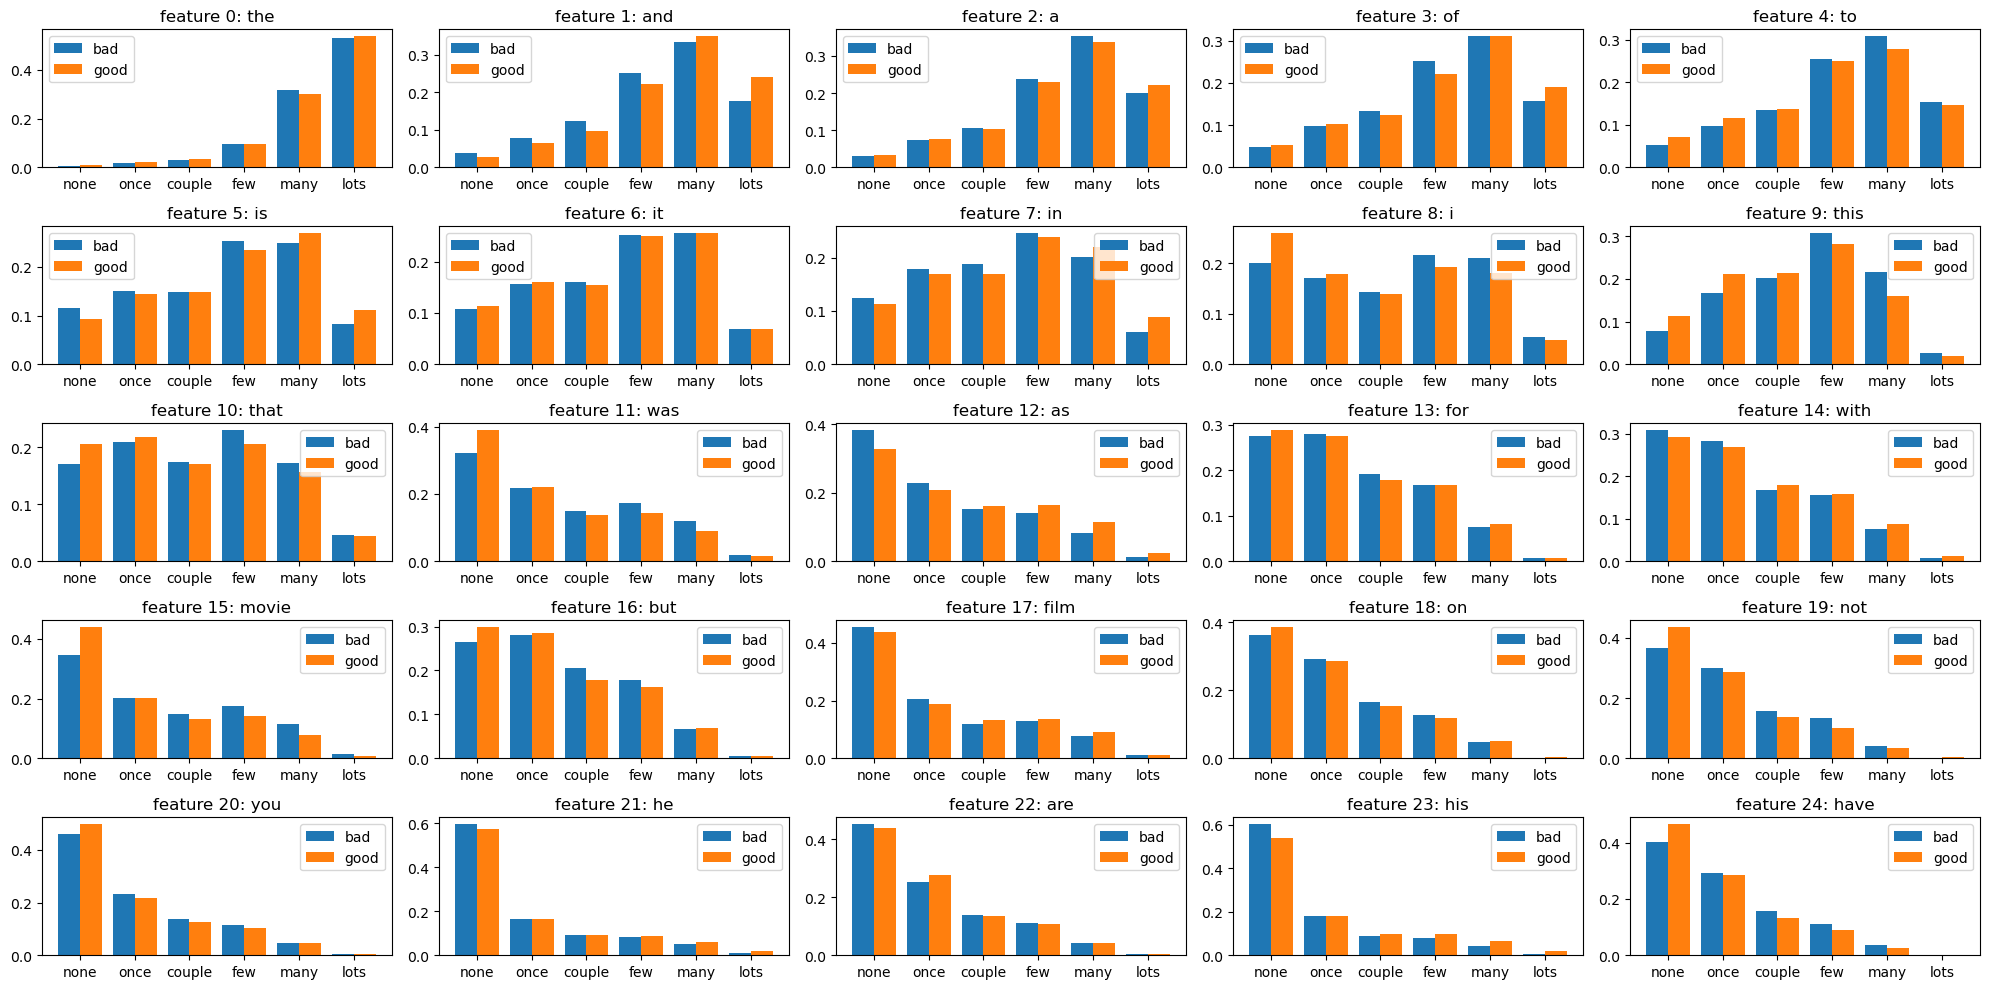

In [3]:
def plotfeaturehist(ds,i):
    f = ds.X[:,i]
    plt.hist((ds.X[ds.Y[:]<0.5,i],ds.X[ds.Y[:]>0.5,i]),density=True,histtype='bar',bins=list(range(len(ds.featcats[i])+1)))
    plt.legend(ds.ycats)
    plt.title(f'feature {i}: {ds.featnames[i]}')
    plt.xticks(ticks=[v+0.5 for v in range(len(ds.featcats[i]))],labels=ds.featcats[i])
    
for i in range(0,25):
    plt.subplot(5,5,i+1)
    plotfeaturehist(train,i)
plt.tight_layout()

## Question 2:

<div style="color: #000000;background-color: #FFFFEE">
    
<b>part a</b> For the 25 features above, based on the histograms you plotted, give an example of a feature that would be particularly helpful for classifying this dataset using naive Bayes?  What is an example of a feature that would not be helpful?  <b>WHY?</b>
</div>    

Features 15 (movie), 9 (this), and 12 (as) are examples of useful features because the histograms for the good and bad classes are the most different.

Features 13 (for), 0 (the), and 6 (it) are the least helpful because the histograms of the two classes are almost exactly the same.

<div style="color: #000000;background-color: #FFFFEE">
    
<b>part b</b> Suggest a way to quantify how good a feature is.  Implement it, and list the three best and three worst feature **out of all 1000** features
</div>
    

In [4]:
def featurescore(ds,i):
    # scores a feature based on the average/expected
    # difference between the log score given to the positive class
    # and the log score given to the negative class
    nval = len(ds.featcats[i])
    hneg = np.sum(ds.X[ds.Y<0.5,i,np.newaxis]==np.arange(0,nval)[np.newaxis,:],axis=0)
    hpos = np.sum(ds.X[ds.Y>0.5,i,np.newaxis]==np.arange(0,nval)[np.newaxis,:],axis=0)
    hneg = hneg+1 # LaPlacian smoothing
    hpos = hpos+1
    hnegsum = hneg.sum()
    hpossum = hpos.sum()
    px = (hneg+hpos)/(hnegsum+hpossum)
    pxgiveny0 = hneg/hnegsum
    pxgiveny1 = hpos/hpossum
    entdiff = px*(np.abs(np.log(pxgiveny0)-np.log(pxgiveny1)))
    entdiff[np.isnan(entdiff)] = 0
    return entdiff.sum()

idxscores = [(i,featurescore(train,i)) for i in range(train.X.shape[1])]
sortedall = sorted(idxscores,key=lambda p: -p[1])

print('best three of all features:')
for i,score in sortedall[:3]:
    print(f'\tfeature {i} ({train.featnames[i]}): {score}')
print('worst three of all features:')
for i,score in sortedall[-3:]:
    print(f'\tfeature {i} ({train.featnames[i]}): {score}')

best three of all features:
	feature 77 (bad): 0.4701981684791944
	feature 83 (great): 0.36887427956163416
	feature 46 (?): 0.3341690501860312
worst three of all features:
	feature 646 (taking): 0.0007918322021642762
	feature 401 (lost): 0.0007707412742437778
	feature 797 (gone): 0.0006995601455345581


## Question 3:

<div style="color: #000000;background-color: #FFFFEE">
        
Complete the two functions in the two cells below.

The first trains/learns a naive Bayes classifier.  The second predicts the classes for a set of examples based on the model learned.
    
Hint:  Test your code on a simpler example where you know the answer.  For instance, the data from Table 3.2 (which can be found as the dataset `tbl3-2`)
    
Hint 2: You will have to deal with counts that are 0.  Leaving them as zero will result in 0 probabilities that will cause problems.  A standard way to handle this is to add 1 to all counts (this is often called Laplace smoothing).  For frequent feature values, it does not change things much.  Do this separately for each table before normalizing.  For infrequent values, it keeps them away from 0 and admits that they might happen more often than was seen in the data.  This is like pretending there are extra examples that cause the raw counts to increase by 1.  
</div>

In [5]:
def learnnb(ds):
    # ds.X is shape (m,n) (m data points, each with n features).  Its elements are integer values from 0 to numfeatvals-1 (inclusive)
    # ds.Y is shape (m,) (m data points).  It has values of either 0 or 1 (class "0" or class "1")
    numfeatvals = len(ds.featcats[0]) # assuming all features have the same number of possible values
    
    # this function is to return a pair (priorp,condp)
    # where priorp is of shape (2,) and has the prior probability of each of the two classes
    #  and  condp is of shape (n,numfeatvals,2) and has the conditional probabilities for the naive Bayes classifier
    
    ## SOLUTIONS
    priorp = np.array([(ds.Y<=0).sum()+1,(ds.Y>0).sum()+1])
    priorp = priorp/priorp.sum() # Laplace smoothing for priors is not necessary, but done here (with the +1 above)
    
    Yind = np.hstack((ds.Y[:,np.newaxis]<=0,ds.Y[:,np.newaxis]>0))
    fcounts = ds.X[:,:,np.newaxis]==((np.arange(numfeatvals))[np.newaxis,np.newaxis,:])
    # fcounts's shape at this point is (m,n,numfeatvals), fcounts[i,j,k] = 1 iff x[i,j] == k (0 otherwise)
    fcounts = fcounts[:,:,:,np.newaxis]*Yind[:,np.newaxis,np.newaxis,:]
    # fcounts's shape at this point is (m,n,mvf,2), fcounts[i,j,k,l] = 1 iff x[i,j]==k and y[i]==l (0 otherwise)
    fcounts = fcounts.sum(axis=0)
    # fcounts's shape at this point is (n,numfeatbals,2), fcounts[j,k,l] = # of times feature j == k at the same time that y==l
    fcounts = fcounts+1 # Laplace smoothing for conditionals
    fcounts = fcounts/(fcounts.sum(axis=1)[:,np.newaxis,:])
    return (priorp,fcounts) # priorp shape = (nclass,) fcounts shape = (nfeat, numfeatvals, nclass)
    

In [6]:
def prednb(X,model,uselog=True):
    # X is of shape (m,n) (m data points, each with n features).
    # model is the pair (priorp,condp), as returned from learnnb
    # should return something of shape (m,) which is an array of 0s and 1s, indicating
    # the predicted (most probable under NB) class for each of the examples in X
    (priorp,condp) = model

    ## SOLUTIONS:
    numfeatval = condp.shape[1]
    if uselog:
        logpriorp = np.log(priorp)
        logcondp = np.log(condp)[np.newaxis,:,:,:]
        Xext = X[:,:,np.newaxis]==((np.arange(numfeatval))[np.newaxis,np.newaxis,:])
        logpr = (logcondp*Xext[:,:,:,np.newaxis]).sum(axis=2).sum(axis=1)
        logpr = logpr+logpriorp
        return logpr.argmax(axis=1)
    else:
        condpnew = condp[np.newaxis,:,:,:]
        Xext = X[:,:,np.newaxis]==((np.arange(numfeatval))[np.newaxis,np.newaxis,:])
        pr = (condpnew*Xext[:,:,:,np.newaxis]).sum(axis=2).prod(axis=1)
        pr = pr*priorp
        return pr.argmax(axis=1)
    

<div style="color: #000000;background-color: #FFFFEE">
The code below trains a naive Bayes classifier and then tests it on the testing examples and reports the error rate.
    
Run the code to report the testing error.
</div>


In [7]:
def errorrate(predY,trueY):
    if len(predY.shape)>1:
        predY = predY[:,0]
    if len(trueY.shape)>1:
        trueY = trueY[:,0]
    return (predY!=trueY).mean()

model = learnnb(train)
predY = prednb(test.X,model)
print(errorrate(predY,test.Y))

0.1846500911970817
